In [1]:
import numpy as np
import simpleaudio as sa
import random
fs = 44100

def play_sinusoide(frequency, seconds):
    # Generate array with seconds*sample_rate steps, ranging between 0 and seconds
    t = np.linspace(0, seconds, int(seconds * fs), False)

    # Generate a 440 Hz sine wave
    note = np.sin(frequency * t * 2 * np.pi)

    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / np.max(np.abs(note))
    # Convert to 16-bit data
    audio = audio.astype(np.int16)

    # Start playback
    play_obj = sa.play_buffer(audio, 1, 2, fs)

    # Wait for playback to finish before exiting
    play_obj.wait_done()

In [2]:
if False:
    frequencies = [440, 880, 660]

    for i in range(10):
        f = random.choice(frequencies)

        play_sinusoide(f, 0.5)


In [3]:
import numpy
import scipy.signal
    
class Note:
    def __init__(self, frequency = 440, duration=1.0, volume=1.0):
        self.frequency = frequency
        self.duration = duration
        self.volume = volume
        
    def create_silence(self):
        # Generate array with seconds*sample_rate steps, ranging between 0 and seconds
        note = np.zeros(int(self.duration * fs))
        return note
    
    def create_sound(self):
        # Generate array with seconds*sample_rate steps, ranging between 0 and seconds
        t = np.linspace(0, self.duration, int(self.duration * fs), False)
        note = np.sin(self.frequency * t * 2 * np.pi) * self.volume
        return note
    
    def __repr__(self):
        return "Note:f=%s,d=%s,v=%s" % (self.frequency, self.duration, self.volume)

def resample(smp, scale=1.0):  
    """Resample a sound to be a different length
    Sample must be mono.  May take some time for longer sounds
    sampled at 44100 Hz.

    Keyword arguments:
    scale - scale factor for length of sound (2.0 means double length)
    From https://stackoverflow.com/questions/37120969/how-can-we-use-scipy-signal-resample-to-downsample-the-speech-signal-from-44100
    """
    import numpy
    # f*ing cool, numpy can do this with one command
    # calculate new length of sample
    n = round(len(smp) * scale)
    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    return numpy.interp(
        numpy.linspace(0.0, 1.0, n, endpoint=False), # where to interpret
        numpy.linspace(0.0, 1.0, len(smp), endpoint=False), # known positions
        smp, # known data points
        )
class PianoNote(Note):
    
    raw_data = None        
    @classmethod
    def raw_data_init(cls):        
        if cls.raw_data is None:
            # From http://theremin.music.uiowa.edu/MISpiano.html
            import audioread
            filename = 'Piano.ff.C4.aiff'

            with audioread.audio_open(filename) as f:
                print(f.channels, f.samplerate, f.duration)
                dat  = [x for x in f]          #Generate list of bytestrings
                dat  = b''.join(dat)             #Join bytestrings into a single urbytestring
                ndat = np.frombuffer(dat, '<i2') #Convert from audioread format to numbers
                ndat = ndat.reshape(-1, 2)
                ndat = ndat[:, 0]
                cls.raw_data = ndat[22000:]
                
        return cls.raw_data
              
    def create_sound(self):
        rd = self.raw_data_init()
        r = self.create_silence()
                    
        resampled = resample(rd, scale=261.63 / self.frequency)
        
        r[:r.shape[0]] = resampled[:r.shape[0]]
        return r                    

        
class Silence(Note):
    def __init__(self, duration):
        super().__init__(0, duration, 0)
        
    
class Music:
    def __init__(self):
        self.elements = []
        
    def add_element(self, element):
        self.elements.append(element)
        
    def add_elements(self, elements):
        for e in elements:
            self.add_element(e)
        
    def create_sound(self):
        s = None
        
        sounds = [e.create_sound() for e in self.elements]
        return numpy.concatenate(sounds)
    
    @staticmethod
    def play_(sound):
        # Ensure that highest value is in 16-bit range
        max_abs = np.max(np.abs(sound))
        if max_abs != 0:
            rescale = (2**15 - 1) / float(max_abs)
        else:
            rescale = 0.0
#        print(max_abs, rescale)
        audio = sound * rescale
        # Convert to 16-bit data
        audio = audio.astype(np.int16)
        # Start playback
        play_obj = sa.play_buffer(audio, 1, 2, fs)

        # Wait for playback to finish before exiting
        play_obj.wait_done()  
    
    def play(self):
        s = self.create_sound()
        Music.play_(s)
        
    def plot(self):
        s = self.create_sound()
        from matplotlib import pyplot as plt

        plt.plot(s)
        


In [4]:
if True:
    m = Music()

    frequencies = [440, 880, 660, 220, 330]

    for i in range(5):
        f = random.choice(frequencies)

        n = PianoNote(frequency = f / 1.5, duration = 1)

        m.add_element(n)        
                
    m.plot()
    m.play()
    
if False:
    m = Music()

    pn = PianoNote(frequency = 220)

    m.add_element(pn)
                
    m.play()
    


2 44100 36.01820861678004


In [5]:
#from https://morsecode.world/international/timing.html

morse_code = {'A':'.-', 'B':'-...',
'C':'-.-.', 'D':'-..', 'E':'.',
'F':'..-.', 'G':'--.', 'H':'....',
'I':'..', 'J':'.---', 'K':'-.-',
'L':'.-..', 'M':'--', 'N':'-.',
'O':'---', 'P':'.--.', 'Q':'--.-',
'R':'.-.', 'S':'...', 'T':'-',
'U':'..-', 'V':'...-', 'W':'.--',
'X':'-..-', 'Y':'-.--', 'Z':'--..',
'1':'.----', '2':'..---', '3':'...--',
'4':'....-', '5':'.....', '6':'-....',
'7':'--...', '8':'---..', '9':'----.',
'0':'-----', ', ':'--..--', '.':'.-.-.-',
'?':'..--..', '/':'-..-.', '-':'-....-',
'(':'-.--.', ')':'-.--.-', ' ': ' '}
        

In [11]:
m = Music()
unit = 0.05
text = "ELEVEN"
frequency = 440
for c in text:
    mc = morse_code[c.upper()]
    
    elements = []
    for d in mc:
#        print(d)
        if d == ".":
            n = Note(frequency = f*1.1, duration = unit)
            s = Silence(duration = unit)
            elements += [n, s]
        elif d == "-":
            n = Note(frequency = f, duration = unit * 3)
            s = Silence(duration = unit)
            elements += [n, s]                
        elif d == " ":
            s = Silence(duration = unit * 4)
            elements = [s]
        else:
            raise Exception("Unknown char %s" % d)
            
    s = Silence(duration = unit * 3)
    m.add_elements(elements)
    m.add_element(s)
                                
m.play()


TypeError: unsupported operand type(s) for *: 'RawAudioFile' and 'float'

In [7]:
# From http://theremin.music.uiowa.edu/MISpiano.html
import audioread
import numpy as np


filename = 'Piano.ff.C4.aiff'

with audioread.audio_open(filename) as f:
    print(f.channels, f.samplerate, f.duration)
    dat  = [x for x in f]          #Generate list of bytestrings
    dat  = b''.join(dat)             #Join bytestrings into a single urbytestring
    ndat = np.frombuffer(dat, '<i2') #Convert from audioread format to numbers
    ndat = ndat.reshape(-1, 2)


#    for buf in f:
#        do_something(buf)
        



2 44100 36.01820861678004


1539.8170407635846
(1588403,)


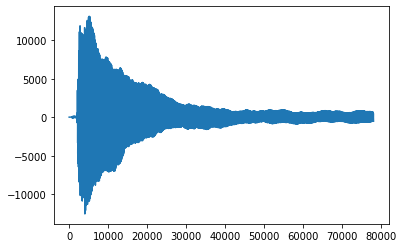

In [8]:
b = ndat[:,0]
print((b * b).mean())
print(b.shape)

    
from matplotlib import pyplot as plt

plt.plot(b[22000:100000])

In [9]:
Music.play_(b[10000:80000])

In [10]:
# Start playback
audio = b.astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()  